## Parameters

感染拡大に関するパラメータ (`disease_spread_params`), 人口に関するパラメータ (`population_params`), 検査に関するパラメータ (`testing_params`) をそれぞれクラスとして定義し、デフォルト値を設定する。

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import time, re
import datetime

iround = lambda x: int((x * 2 + 1) // 2)

class Disease_spread_params:
    '''
    R_uncontolled: 初期段階の再生産率
    R_intermediate: 中間段階の再生産率
    R_lockdown: ロックダウン段階の再生産率
    cluster: ?不明?
    begin_intermediate: 中間段階に入る世代番号
    begin_lockdown: ロックダウン段階に入る世代番号
    severe: 感染すると重症になる割合
    mild: 感染すると中等症になる割合
    asymptomatic: 感染しても無症状の割合
    '''
    def __init__(self,
                 R_uncontrolled = 2.7,
                 R_intermediate = 1.4,
                 R_lockdown = 0.7,
                 cluster = 0.5,
                 begin_intermediate = 11,
                 begin_lockdown = 15,
                 mild = 0.6,
                 asymptomatic = 0.3,
                 zero_date = '2020-01-01',
                 serial = 5):
        self.R_uncontrolled = R_uncontrolled
        self.R_intermediate = R_intermediate
        self.R_lockdown = R_lockdown
        self.cluster = cluster
        self.begin_intermediate = begin_intermediate
        self.begin_lockdown = begin_lockdown
        self.severe = 1 - mild - asymptomatic
        self.mild = mild
        self.asymptomatic = asymptomatic
        self.zero_date = zero_date
        self.serial = serial

class Population_params:
    '''
    population: この国の総人口
    initial_infection: 世代0の感染者数
    faux_severe: コロナウィルス以外を原因とする重症者の割合
    faux_mild: コロナウィルス以外を原因とする中等症者の割合
    desire_severe: 重症者が検査を求める割合
    desire_mild: 中等症者が検査を求める割合
    desire_asymptomatic: 無症状者が検査を求める割合
    '''
    def __init__(self,
                 population = 10_000_000,
                 initial_infection = 1,
                 faux_severe = 0.001,
                 faux_mild = 0.025,
                 desire_severe = 1.0,
                 desire_mild = 0.5,
                 desire_asymptomatic = 0.02):
        self.population = population
        self.initial_infection = initial_infection
        self.faux_severe = faux_severe
        self.faux_mild = faux_mild
        self.desire_severe = desire_severe
        self.desire_mild = desire_mild
        self.desire_asymptomatic = desire_asymptomatic

class Testing_params:
    '''
    initial_tests: 初期段階の検査数
    ramp_period: 検査数を増加させる期間
    test_growth_rate: 検査を増加させる割合
    test_max: 検査の最大数
    rationed_test_ratio: 重症者に回すテストの割合
    false_negative: 検査の偽陰性の割合
    false_positive: 検査の偽陽性の割合
    delay: 発生から検査報告までの遅延(世代数)
    '''
    def __init__(self,
                 initial_tests = 1_000,
                 ramp_period = 3,
                 test_growth_rate = 0.5,
                 test_max = 10_000_000,
                 rationed_test_ratio = 0.75,
                 false_negative = 0.20,
                 false_positive = 0.002,
                 delay = 2):
        self.initial_tests = initial_tests
        self.ramp_period = ramp_period
        self.test_growth_rate = test_growth_rate
        self.test_max = test_max
        self.rationed_test_ratio = rationed_test_ratio
        self.false_negative = false_negative
        self.false_positive = false_positive
        self.delay = delay

## シミュレーター

In [2]:
class Simulator:
    def __init__(self,
                 disease_spread_params,
                 population_params,
                 testing_params):
        self.disease_spread_params = disease_spread_params
        self.population_params = population_params
        self.testing_params = testing_params
        
        self.columns = [ 'date', 'actual.R', 'doubling time in days' ]
        self.date_regex = re.compile('(\d+)-(\d+)-(\d+)')
        
    def decode_date(self, date):
            match = self.date_regex.fullmatch(date)
            if match:
                y, m, d = match.group(1, 2, 3)
                timestamp = time.mktime((int(y), int(m), int(d), 0, 0, 0, -1, -1, -1))
                return timestamp
            return None
    
    def encode_date(self, timestamp):
        t = time.localtime(timestamp)
        return '{0:04d}-{1:02d}-{2:02d}'.format(t[0], t[1], t[2])

    def run(self, zero_day = '2020-01-01', generations = 40):
        '''
        シミュレーションを実行して、pd.DataFrame を返す
        
        Args:
        zero_day: 最初の日付 (2020-01-01)
        generations: シミュレーションする世代数

        Returns:
        シミュレーション結果の DataFrame
        '''
        self.generations = generations
        self.df = pd.DataFrame(index = range(0, self.generations))
        t0 = self.decode_date(zero_day)
        self.df['date'] = [ self.encode_date(t0 + d * self.disease_spread_params.serial * 24 * 60 * 60) for d in range(0, self.generations) ]

        self.set_target_R()
        self.compute_actual_infection()
        self.compute_tests()
        
        return self.df

    def set_target_R(self):
        '''
        パラメータに従って、計算の元となる R を設定する。
        
        Columns:
        target_R: パラメータに従って設定された R
        '''
        begin_lockdown = self.disease_spread_params.begin_lockdown
        begin_intermediate = self.disease_spread_params.begin_intermediate
        self.df['target_R'] = np.NaN
        
        for i in range(0, self.generations):
            if begin_lockdown != None and i >= begin_lockdown:
                self.df.at[i, 'target_R'] = self.disease_spread_params.R_lockdown
            elif  begin_intermediate != None and i >= begin_intermediate:
                self.df.at[i, 'target_R'] = self.disease_spread_params.R_intermediate
            else:
                self.df.at[i, 'target_R'] = self.disease_spread_params.R_uncontrolled

    def compute_actual_infection(self):
        '''
        実際の感染の広がりを計算。これは本当は観測できない。
        
        Columns:
        susceptible: 感染する可能性のある人数
        new_infection: 実際に感染した人数
        cumulative_infection: 実際に感染した人の積算
        actual_R: 実際の感染数から計算した再生産率
        actual_doubling_time: 実際の感染数から計算した倍化時間 (日数)
        '''
        population = self.population_params.population
        initial_infection = self.population_params.initial_infection
        cluster = self.disease_spread_params.cluster
        serial = self.disease_spread_params.serial

        df = self.df
        df['susceptible'] = np.NaN
        df.at[0, 'susceptible'] = population - initial_infection
        df['new_infection'] = np.NaN
        df.at[0, 'new_infection'] = initial_infection
        df['cumulative_infection'] = np.NaN
        df.at[0, 'cumulative_infection'] = initial_infection
        df['actual_R'] = np.NaN
        df['actual_doubling_time'] = np.NaN
        
        for i in range(1, self.generations):
            df.at[i, 'new_infection'] = iround(df.at[i-1, 'susceptible']*(1-(1-((df.at[i-1, 'target_R']*(df.at[i-1, 'susceptible']/population)**cluster)/population))**df.at[i-1, 'new_infection']))
            df.at[i, 'cumulative_infection'] = df.at[i-1, 'cumulative_infection'] + df.at[i, 'new_infection']
            df.at[i, 'susceptible'] = population - df.at[i, 'cumulative_infection']
            df.at[i-1, 'actual_R'] = df.at[i, 'new_infection'] / df.at[i-1, 'new_infection']
            if df.at[i-1, 'cumulative_infection'] != 0:
                df.at[i-1, 'actual_doubling_time'] = np.inf if df.at[i, 'new_infection'] == 0 else serial * np.log(2) / np.log(df.at[i, 'cumulative_infection']/df.at[i-1, 'cumulative_infection'])

    def compute_tests(self):
        '''
        検査できるキャパシティを計算し、感染者の種類 (severe, mild, asymptomatic) ごとに検査で検出される人数を計算。
        
        Columns:
        test_available: 検査できる数 (パラメータに基づく)
        new_detected_cases: 検査結果が陽性となる件数
        cumulative_detected_cases: 検査結果が陽性となった件数の積算
        observed_R: 観測された再生産率
        observed_doubling_time: 観測された倍化時間 (日数)
        '''
        population = self.population_params.population
        ramp_period = self.testing_params.ramp_period
        tests_max = self.testing_params.test_max
        test_growth_rate = self.testing_params.test_growth_rate
        rationed_test_ratio = self.testing_params.rationed_test_ratio
        mild = self.disease_spread_params.mild
        asymptomatic = self.disease_spread_params.asymptomatic
        faux_severe = self.population_params.faux_severe
        faux_mild = self.population_params.faux_mild
        desire_severe = self.population_params.desire_severe
        desire_mild = self.population_params.desire_mild
        desire_asymptomatic = self.population_params.desire_asymptomatic
        false_negative = self.testing_params.false_negative
        false_positive = self.testing_params.false_positive
        delay = self.testing_params.delay
        serial = self.disease_spread_params.serial        

        cumulative_tests_conducted = 0
        cumulative_detected_cases = 0
        
        df = self.df
        df['tests_available'] = 0
        df['new_detected_cases'] = 0
        df['cumulative_detected_cases'] = 0
        
        for i in range(0, self.generations):
            if i  == 0:
                df.at[i, 'tests_available'] = 0
            elif i == 1:
                df.at[i, 'tests_available'] = self.testing_params.initial_tests
            elif i < ramp_period:
                df.at[i, 'tests_available'] = df.at[i-1, 'tests_available']
            else:
                df.at[i, 'tests_available'] = iround(min(tests_max, df.at[i-1, 'tests_available'] * (1 + test_growth_rate)))
            tests_available = df.at[i, 'tests_available']
            rationed_tests =  iround(tests_available * rationed_test_ratio)
            on_demand_tests = tests_available - rationed_tests

            new_infection_severe = iround(df.at[i, 'new_infection'] * (1 - mild - asymptomatic))
            new_infection_mild = iround(df.at[i, 'new_infection'] * mild)
            new_infection_asymptomatic = df.at[i, 'new_infection'] - new_infection_severe - new_infection_mild
            
            population_severe = iround((population - df.at[i, 'new_infection']) * faux_severe) + new_infection_severe
            population_mild = iround((population - df.at[i, 'new_infection']) * faux_mild) + new_infection_mild
            population_asymptomatic = population - population_severe - population_mild
            
            desiring_tests_severe = iround(population_severe * desire_severe * (1 - cumulative_tests_conducted/population))
            desiring_tests_mild = iround(population_mild * desire_mild * (1 - cumulative_tests_conducted/population))
            desiring_tests_asymptomatic = iround(population_asymptomatic * desire_asymptomatic * (1 - cumulative_tests_conducted/population))
            
            alloc_rationed_tests_severe = min(rationed_tests, desiring_tests_severe)
            alloc_rationed_tests_mild = min(desiring_tests_mild, rationed_tests-alloc_rationed_tests_severe)
            alloc_rationed_tests_asymptomatic = min(desiring_tests_asymptomatic, rationed_tests-alloc_rationed_tests_severe-alloc_rationed_tests_mild)

            unfilled_test_demand_severe = desiring_tests_severe - alloc_rationed_tests_severe
            unfilled_test_demand_mild = desiring_tests_mild - alloc_rationed_tests_mild
            unfilled_test_demand_asymptomatic = desiring_tests_asymptomatic - alloc_rationed_tests_asymptomatic
            unfilled_test_demand = unfilled_test_demand_severe + unfilled_test_demand_mild + unfilled_test_demand_asymptomatic
            
            alloc_on_demand_tests_severe = 0 if unfilled_test_demand == 0 else iround(on_demand_tests * unfilled_test_demand_severe / unfilled_test_demand)
            alloc_on_demand_tests_mild = 0 if unfilled_test_demand == 0 else iround(on_demand_tests * unfilled_test_demand_mild / unfilled_test_demand)
            alloc_on_demand_tests_asymptomatic = 0 if unfilled_test_demand == 0 else iround(on_demand_tests * unfilled_test_demand_asymptomatic / unfilled_test_demand)
            
            tests_conducted_severe = alloc_rationed_tests_severe + alloc_on_demand_tests_severe
            tests_conducted_mild = alloc_rationed_tests_mild + alloc_on_demand_tests_mild
            tests_conducted_asymptomatic = alloc_rationed_tests_asymptomatic + alloc_on_demand_tests_asymptomatic
            tests_conducted = tests_conducted_severe + tests_conducted_mild + tests_conducted_asymptomatic
            cumulative_tests_conducted += tests_conducted
            
            positive_tests_severe = iround(tests_conducted_severe * new_infection_severe / population_severe * (1 - false_negative)) + \
              iround(tests_conducted_severe * (1 - new_infection_severe / population_severe) * false_positive)
            positive_tests_mild = iround(tests_conducted_mild * new_infection_mild / population_mild * (1 - false_negative)) + \
              iround(tests_conducted_mild * (1 - new_infection_mild / population_mild) * false_positive)
            positive_tests_asymptomatic = iround(tests_conducted_asymptomatic * new_infection_asymptomatic / population_asymptomatic * (1 - false_negative)) + \
              iround(tests_conducted_asymptomatic * (1 - new_infection_asymptomatic / population_asymptomatic) * false_positive)
            if i+delay < self.generations:
                df.at[i+delay, 'new_detected_cases'] = positive_tests_severe + positive_tests_mild + positive_tests_asymptomatic

            cumulative_detected_cases += df.at[i, 'new_detected_cases']
            df.at[i, 'cumulative_detected_cases'] = cumulative_detected_cases

            if i > 0 and df.at[i-1, 'new_detected_cases'] > 0:
                df.at[i-1, 'observed_R'] = df.at[i, 'new_detected_cases'] / df.at[i-1, 'new_detected_cases']
                df.at[i-1, 'observed_doubling_time'] = np.inf if df.at[i, 'new_detected_cases'] == 0 else serial * np.log(2) / np.log(df.at[i, 'cumulative_detected_cases']/df.at[i-1, 'cumulative_detected_cases'])

## Covidia Scenario 1: Robust testing

当初は1,000件/世代の検査。３世代目から50%/世代のスピードで検査を増やすシナリオ。

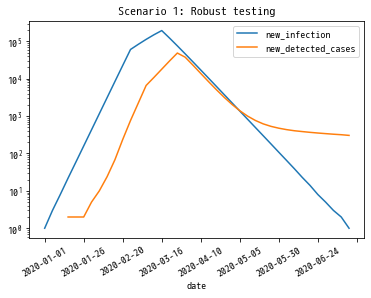

In [3]:
# パラメータ設定 for Scenario 1
disease_spread_params = Disease_spread_params()
population_params = Population_params()
testing_params = Testing_params()

# 実行
simulator = Simulator(disease_spread_params, population_params, testing_params)
df = simulator.run()

# plot
df = df.set_index('date').loc[:, ['new_infection', 'new_detected_cases']].replace(0, np.NaN)
df.plot(logy=True, title='Scenario 1: Robust testing', rot=30)

## Covidia Scenario 2: Sudden, one-time increase in testing

当初は５００件/世代しか検査しないが、急激にテストを増やして25,000件/世代で検査を行うシナリオ。

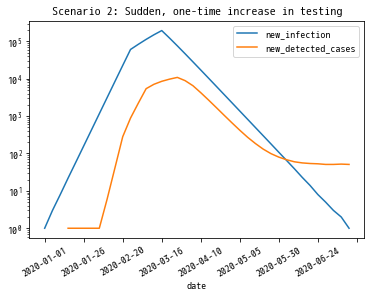

In [4]:
# パラメータ設定 for Scenario 2
disease_spread_params = Disease_spread_params()
population_params = Population_params()
testing_params = Testing_params(
    initial_tests = 500,
    ramp_period = 6,
    test_growth_rate = 2,
    test_max = 25000,
)

# 実行
simulator = Simulator(disease_spread_params, population_params, testing_params)
df = simulator.run()

# plot
df = df.set_index('date').loc[:, ['new_infection', 'new_detected_cases']].replace(0, np.NaN)
df.plot(logy=True, title='Scenario 2: Sudden, one-time increase in testing', rot=30)

## Covidia Scenario 3: High test floor, low test ceiling

初めから10,000件/世代の検査を行うが、徐々に増やしながらも20,000件/世代以上のテストを行わないシナリオ。

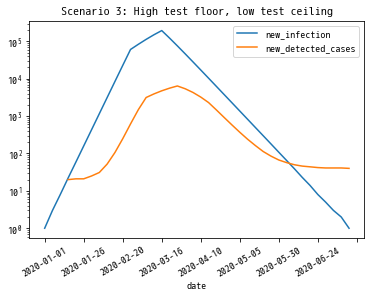

In [5]:
# パラメータ設定 for Scenario 3
disease_spread_params = Disease_spread_params()
population_params = Population_params()
testing_params = Testing_params(
    initial_tests = 10000,
    ramp_period = 3,
    test_growth_rate = 0.03,
    test_max = 20000,
)

# 実行
simulator = Simulator(disease_spread_params, population_params, testing_params)
df = simulator.run()

# plot
df = df.set_index('date').loc[:, ['new_infection', 'new_detected_cases']].replace(0, np.NaN)
df.plot(logy=True, title='Scenario 3: High test floor, low test ceiling', rot=30)

## Covidia Scenario 4: A testing decrease

当初、10,000件/世代の検査を行うが、２％/世代のスピードで検査を減らしていくシナリオ。

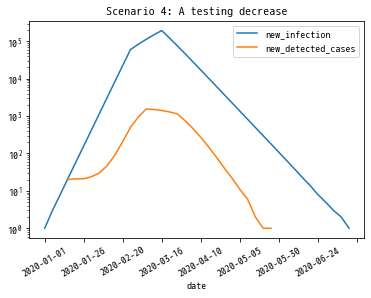

In [6]:
# パラメータ設定 for Scenario 4
disease_spread_params = Disease_spread_params()
population_params = Population_params()
testing_params = Testing_params(
    initial_tests = 10000,
    ramp_period = 10,
    test_growth_rate = -0.2,
    test_max = 10000,
)

# 実行
simulator = Simulator(disease_spread_params, population_params, testing_params)
df = simulator.run()

# plot
df = df.set_index('date').loc[:, ['new_infection', 'new_detected_cases']].replace(0, np.NaN)
df.plot(logy=True, title='Scenario 4: A testing decrease', rot=30)